# Datavalanche

## Exploratory data analysis of the SLF deadly avalanche dataset

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date

In [62]:
def parsedate(ts):
    return date.fromtimestamp(int(ts))

data = pd.read_csv('data/avalanches.csv', parse_dates=['date_posix_ts'], date_parser=parsedate)

In [63]:
data.head()

,winter,date_posix_ts,canton,community,starting_zone_Y,starting_zone_X,elevation,aspect_id,aspect_string,activity,victims,caught,buried,danger_level
0,2015/16,2016-07-04,VS,Baltschieder,631760,138570,3440,5,E,1,1,2,0,0
1,2015/16,2016-05-05,GR,Flims,737700,197340,2900,6,ESE,1,1,1,1,0
2,2015/16,2016-04-29,VS,Naters,640290,146390,3680,11,SW,1,1,2,1,2
3,2015/16,2016-04-20,GR,Sils im Engadin/Segl,781510,135430,2810,3,NE,1,1,1,1,3
4,2015/16,2016-04-19,VS,Orsières,570830,93228,3100,2,NNE,2,1,2,1,3


Let's see how many deadly avalanches occurred each year during the last 20 years

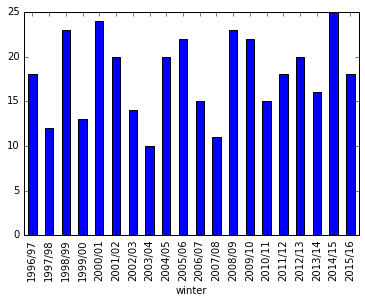

In [52]:
avalanches_per_winter = data.groupby('winter').count()['canton']
avalanches_per_winter.plot(kind='bar')

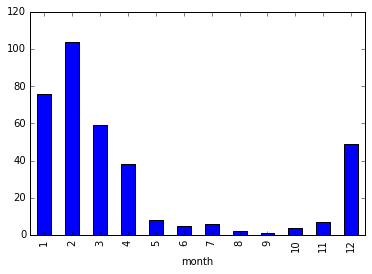

In [70]:
data['month'] = data['date_posix_ts'].map(lambda x: x.month)
avalanches_per_month = data.groupby('month').count()['canton']
avalanches_per_month.plot(kind='bar')

TODO: we should try to compare this with data about total quantities of snow per year/month !


Let's now look at the aspect of the slopes where the avalanches occurred.

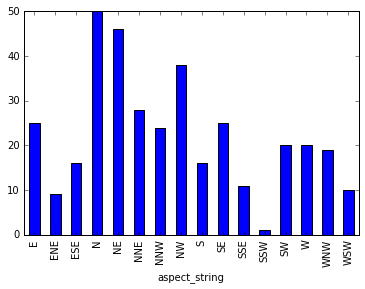

In [53]:
avalanches_per_aspect = data.groupby('aspect_string').count()['canton']
avalanches_per_aspect.plot(kind='bar')

It seems that north facing slopes are more dangerous. TODO: statistical test ?

Avalanches per danger level: TODO compare this with average proportion of days with given danger level during a winter (we should be abl to find this on the SLF website)

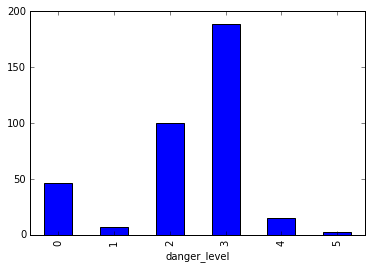

In [54]:
avalanches_per_danger = data.groupby('danger_level').count()['canton']
avalanches_per_danger.plot(kind='bar')

Let's see the distribution of avalanche starting point elevation

Mean avalanche start point elevation: 2519.9526462395543


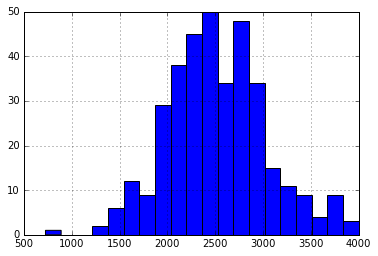

In [92]:
print('Mean avalanche start point elevation:', data['elevation'].mean())
data['elevation'].hist(bins=20)

Mean avalanche start point elevation: 2755.869918699187


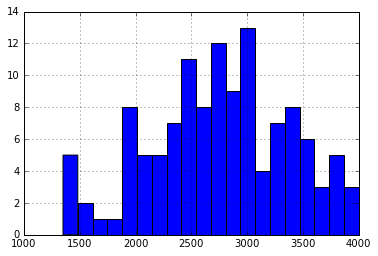

In [93]:
# TODO: maybe not so useful...
# Usually we don't go at high altitudes during the winter.
# Let's see if the mean altitude changes when not taking into account winter months
filtered_elevations = data[(data['month'] > 2) & (data['month'] < 11)]['elevation']
print('Mean avalanche start point elevation:', filtered_elevations.mean())
filtered_elevations.hist(bins=20)

In [ ]:
# TODO: Some fancy map with avalanches per canton :D ?